In [1]:
import random
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import  tensorflow.keras.backend as k
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from sklearn import decomposition

In [2]:
tf.__version__

'2.1.0'

In [3]:
#load data
(x_train,y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Normalization is a rescaling of the data from the original range so that all values are within the range of 0 and 1.
x_train /= 255
x_test /= 255


In [4]:
def make_pairs(x,y):
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    
    pairs = []
    labels = []
    for i in range(len(x)):
        x1 = x[i]
        label1 = y[i]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        
        pairs += [[x1,x2]]
        labels += [1]
        
        #add a not matching 
        label2 = random.randint(0, num_classes-1)
        while label2 == label1:
            label2 = random.randint(0, num_classes-1)
        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
            
        pairs += [[x1,x2]]
        labels += [0]
    return np.array(pairs), np.array(labels)
            

In [5]:
pairs_train, labels_train = make_pairs(x_train, y_train)
pairs_test, labels_test = make_pairs(x_test, y_test)

In [6]:
print(pairs_train.shape, labels_train.shape)
print(pairs_test.shape, labels_test.shape)

(120000, 2, 28, 28) (120000,)
(20000, 2, 28, 28) (20000,)


0


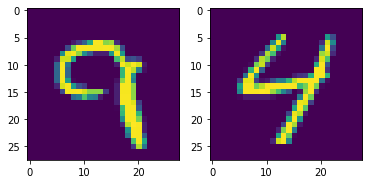

In [7]:
#plot pairs
idx = random.randint(0, pairs_train.shape[0])


fig = plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(pairs_train[idx,0])

plt.subplot(1, 2, 2)
plt.imshow(pairs_train[idx,1])
# zero méans the pairs are not the same while one means vice versa
print(labels_train[idx])

In [9]:
def euclidean_distance(vects):
    x,y = vects
    sum_square = k.sum(k.square(x-y), axis=1, keepdims=True)
    sqrt = k.sqrt(k.maximum(sum_square, k.epsilon()))
    return sqrt

In [10]:
# create model
input = Input((28,28))
x = Flatten()(input)
x = Dense(10) (x)
x = Dense(128, activation='relu')(x)
dense = Model(input, x)

input1 = Input((28,28))
input2 = Input((28,28))

dense1 = dense(input1)
dense2 = dense(input2)

merge_layer = Lambda(euclidean_distance)([dense1,dense2])
dense_layer = Dense(1, activation='sigmoid')(merge_layer)
model = Model (inputs = [input1,input2], outputs = dense_layer)

In [11]:
model.compile(loss ='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [12]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

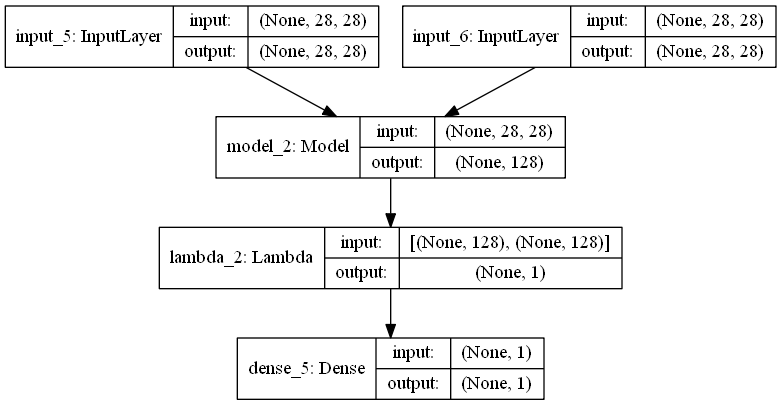

In [13]:
model.fit([pairs_train[:,0],pairs_train[:,1]], labels_train[:], batch_size=32, epochs=20)

Train on 120000 samples
Epoch 1/20
120000/120000 [==============================] - 7s 54us/sample - loss: 0.4553 - acc: 0.7930
Epoch 2/20
120000/120000 [==============================] - 5s 42us/sample - loss: 0.3110 - acc: 0.8825
Epoch 3/20
120000/120000 [==============================] - 5s 42us/sample - loss: 0.2768 - acc: 0.8937
Epoch 4/20
120000/120000 [==============================] - 5s 42us/sample - loss: 0.2522 - acc: 0.9022
Epoch 5/20
120000/120000 [==============================] - 5s 42us/sample - loss: 0.2370 - acc: 0.9083
Epoch 6/20
120000/120000 [==============================] - 5s 46us/sample - loss: 0.2294 - acc: 0.9112
Epoch 7/20
120000/120000 [==============================] - 5s 45us/sample - loss: 0.2200 - acc: 0.9162
Epoch 8/20
120000/120000 [==============================] - 5s 44us/sample - loss: 0.2138 - acc: 0.9188
Epoch 9/20
120000/120000 [==============================] - 5s 42us/sample - loss: 0.2105 - acc: 0.9198
Epoch 10/20
120000/120000 [=============


## Visualizing Weights using the PCA

Using the PCA, I can graphically represent high dimensional embeddings. This can be helpful in visualizing, examining, and understanding your embedding layers.


In [14]:
# Get the weights of the embedding layer
weights = tf.Variable(dense.layers[3].get_weights()[0])
print(weights.shape)

(10, 128)


In [15]:
# n_components = numbers of dimenstions you want to retain
pca = decomposition.PCA(n_components=2)
pca_data = pca.fit_transform(weights.numpy())


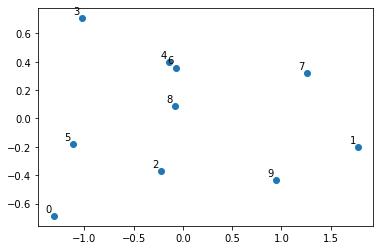

In [16]:
# plot weights
names = [str(i) for i in range(10)]
plt.scatter(pca_data[:,0],pca_data[:,1])
for label, x, y in zip(names, pca_data[:,0], pca_data[:,1]):
    plt.annotate( label, xy=(x, y), xytext=(-2, 2), textcoords='offset points', ha='right', va='bottom' )
plt.show()

# Evaluate Model on the test dataset

In [17]:
score, acc = model.evaluate([pairs_test[:,0],pairs_test[:,1]], labels_test[:],batch_size=25, verbose=2)
print('Test score:', score) #Score is the evaluation of the loss function for a given input.
print('Test accuracy:', acc)

20000/20000 - 1s - loss: 0.2097 - acc: 0.9189
Test score: 0.209654268338345
Test accuracy: 0.91885


# Test Model on the Fashion MNIST dataset

In [20]:
(f_x_train, f_y_train), (f_x_test, f_y_test)= tf.keras.datasets.fashion_mnist.load_data()
f_x_train = f_x_train.astype('float32')
f_x_test = f_x_test.astype('float32')
f_x_train /= 255
f_x_test /= 255

In [26]:
num_classes = max(f_y_train) + 1
digit_indices = [np.where(f_y_train == i)[0] for i in range(num_classes)]

f_idx = random.randint(0, num_classes-1)
pair1 = f_x_train[random.choice(digit_indices[f_idx])]
pair2 = f_x_train[random.choice(digit_indices[f_idx])]

(28, 28)


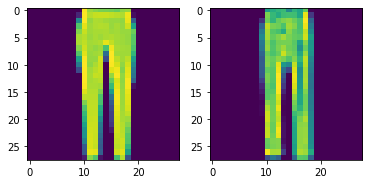

In [27]:
# plot pairs
fig = plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(pair1)

plt.subplot(1, 2, 2)
plt.imshow(pair2)


print(pair1.shape)

In [29]:
input1 = np.expand_dims(pair1,0)
input2 = np.expand_dims(pair2,0)

In [30]:
#make prediction
model.predict([input1,input2])

array([[0.9998312]], dtype=float32)